## CLASS FOR DATA PREPARATION

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder,LabelBinarizer

class PandasSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x):
        return x.loc[:,self.columns]

class ExtractNameAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, attributes=["lname","title","spname"]):
        self.attributes = attributes
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x):
        x = x.iloc[:,0]
        data = pd.DataFrame()
        try:
            data[self.attributes[0]] = x.map(lambda x:x.split(',')[0].strip())
            data[self.attributes[1]] = x.str.extract("\,(.*?)\.", expand=False)
            try:
                data[self.attributes[2]] = x.map(lambda x:x.split('.')[1].split('(')[0].strip())
            except IndexError:
                data[self.attributes[2]] = x.map(lambda x:x.split('.')[1].strip())
            ## data[self.attributes[3]] = x.str.extract("\((.*?)\)", expand=False) 1088 out of 1309 are invalid
        except:
            pass
        return data
    
class LabelEncoderPipelineFriendly(LabelEncoder):   
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelEncoderPipelineFriendly, self).fit(X)
    def transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).transform(X)

    def fit_transform(self, X, y=None):
        for colname in X:
            X[colname] = super(LabelEncoderPipelineFriendly, self).fit(X[colname]).transform(X[colname])
        return X


class NullFiller(BaseEstimator, TransformerMixin):
    def __init__(self,colname):
        self.colname = colname
        pass
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x):
        sc = self.colname[0]
        dfs = x.groupby([sc])[sc].agg({"percentage": np.size})/len(x)
        dfs = dfs.reset_index()
        xval = np.max(dfs["percentage"])
        xlab = dfs[dfs["percentage"] == xval]
        x = x.fillna(xlab[sc].values[0])
        return x
    
class PandasToArr(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, x, y = None):
        return self
    
    def transform(self, x):
        for colname in x:
            x[colname] = x[colname].values.reshape(-1, 1) 
        return x



## TITANIC CODE 

In [68]:
import numpy as np 
import pandas as pd 

In [132]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

com_df = test_df.append(train_df) 

In [70]:
print(len(com_df),len(test_df),len(train_df))
com_df.head(5)

1309 418 891


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,34.5,NaN,Q,7.8292,"Kelly, Mr. James",0,892,3,male,0,NaN,330911
1,47.0,NaN,S,7.0000,"Wilkes, Mrs. James (Ellen Needs)",0,893,3,female,1,NaN,363272
2,62.0,NaN,Q,9.6875,"Myles, Mr. Thomas Francis",0,894,2,male,0,NaN,240276
3,27.0,NaN,S,8.6625,"Wirz, Mr. Albert",0,895,3,male,0,NaN,315154
4,22.0,NaN,S,12.2875,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,896,3,female,1,NaN,3101298


In [71]:
com_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 890
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


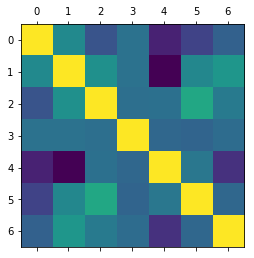

In [133]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.matshow(com_df.corr())

In [134]:
ageMean = com_df['Age'].sum()/len(com_df[~com_df['Age'].isnull()])

In [135]:
com_df['AgeClass'] = 0
com_df['Age'] = com_df['Age'].fillna(int(ageMean))
for row in com_df.itertuples():
    curage = row.Age
    if (curage < 5):
        com_df.loc[row.Index, 'AgeClass'] = 5
    elif(curage >= 5 and curage < 15 ):
        com_df.loc[row.Index, 'AgeClass'] = 15
    elif(curage >= 15 and curage < 25 ):
        com_df.loc[row.Index, 'AgeClass'] = 25
    elif(curage >= 25 and curage < 35 ):
        com_df.loc[row.Index, 'AgeClass'] = 35
    elif(curage >= 35 and curage < 45 ):
        com_df.loc[row.Index, 'AgeClass'] = 45
    else:
        com_df.loc[row.Index, 'AgeClass'] = 145
#com_df['Age'].groupby(com_df['Age']).sum().plot.bar()

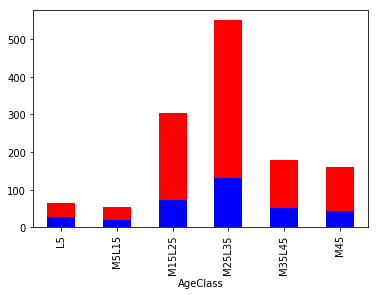

In [170]:
%matplotlib inline
import matplotlib.pyplot as plt
com_df_sr = com_df[com_df['Survived'] == 1]
com_df['AgeClass'].groupby(com_df['AgeClass']).size().plot.bar(color='r').set_xticklabels(('L5', 'M5L15', 'M15L25', 'M25L35', 'M35L45', 'M45'))
com_df_sr['AgeClass'].groupby(com_df_sr['AgeClass']).size().plot.bar(color='b').set_xticklabels(('L5', 'M5L15', 'M15L25', 'M25L35', 'M35L45', 'M45'))

In [137]:
com_df['AgeClass'].groupby(com_df['AgeClass']).size()

AgeClass
5       63
15      53
25     303
35     551
45     179
145    160
Name: AgeClass, dtype: int64

In [138]:
len(com_df[(com_df['AgeClass'] == 5) & (com_df['Survived'] == 0)])

13

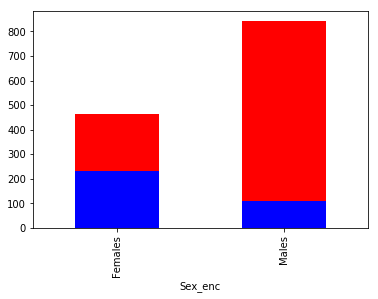

In [169]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

leb_enc = LabelEncoder()
com_df['Sex_enc'] = leb_enc.fit_transform(com_df['Sex'])
com_df_sr = com_df[com_df['Survived'] == 1]

com_df['Sex_enc'].groupby(com_df['Sex_enc']).size().plot.bar(color='r').set_xticklabels(('Females', 'Males'))
com_df_sr['Sex_enc'].groupby(com_df_sr['Sex_enc']).size().plot.bar(color='b').set_xticklabels(('Females', 'Males'))

In [152]:
len(com_df[(com_df['Sex_enc'] == 1) & (com_df['Survived'] == 0)])

468

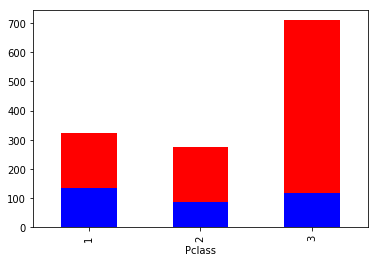

In [168]:
%matplotlib inline
import matplotlib.pyplot as plt
com_df_sr = com_df[com_df['Survived'] == 1]
com_df['Pclass'].groupby(com_df['Pclass']).size().plot.bar(color='r')
com_df_sr['Pclass'].groupby(com_df_sr['Pclass']).size().plot.bar(color='b')

In [125]:
len(com_df[(com_df['Pclass'] == 3) & (com_df['Survived'] == 0)])

372

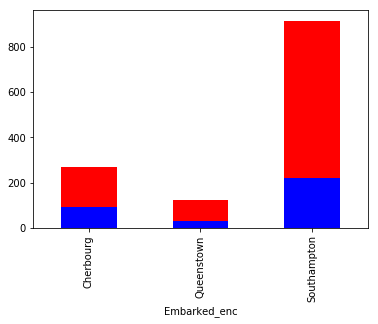

In [171]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

leb_enc = LabelEncoder()
com_df['Embarked'] = com_df['Embarked'].fillna('S')
com_df['Embarked_enc'] = leb_enc.fit_transform(com_df['Embarked'])
com_df_sr = com_df[com_df['Survived'] == 1]
com_df['Embarked_enc'].groupby(com_df['Embarked_enc']).size().plot.bar(color='r').set_xticklabels(('Cherbourg', 'Queenstown','Southampton'))
com_df_sr['Embarked_enc'].groupby(com_df_sr['Embarked_enc']).size().plot.bar(color='b').set_xticklabels(('Cherbourg', 'Queenstown','Southampton'))

In [148]:
com_df[['Embarked','Embarked_enc']].head()

,Embarked,Embarked_enc
0,Q,1
1,S,2
2,Q,1
3,S,2
4,S,2


## TITANIC PIPELINE

In [198]:
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.preprocessing import StandardScaler

## Use lable Encoders and Binarizers before the PipleLine 
#lb_enc = LabelEncoder()
#com_df['Embarked_enc'] = lb_enc.fit_transform(com_df['Embarked'])
#com_df['Sex_enc'] = lb_enc.fit_transform(com_df['Sex'])

##PipeLine 
processing_pipeline = make_pipeline(
    # Select used variables
    PandasSelector(["Age", "Embarked", 
                    "Fare", "Name", "Parch",
                    "PassengerId", "Pclass",
                    "Sex", "SibSp", "Ticket"]),
    
    # combine features
    make_union(
        make_pipeline(
            PandasSelector(["Age"]),
            Imputer(strategy='mean'),
            StandardScaler()
        ),
        make_pipeline(
            PandasSelector(["Fare"]),
            Imputer(strategy='mean'),
            StandardScaler()
        ),
        make_pipeline(
            PandasSelector(["Embarked","Sex"]),
            NullFiller(["Embarked","Sex"]),
            LabelEncoderPipelineFriendly(),
            PandasToArr(),
            StandardScaler()
        ),
        make_pipeline(
            PandasSelector(["Name"]),
            ExtractNameAttributes(),
            LabelEncoderPipelineFriendly(),
            PandasToArr(),
            StandardScaler()
        ),
        make_pipeline(
            PandasSelector(["Ticket"]),
            LabelEncoderPipelineFriendly(),
            PandasToArr(),
            StandardScaler()
        ),
        make_pipeline(
            PandasSelector(["Pclass","Parch","SibSp"]),
            PandasToArr(),
            StandardScaler()
        )
    )    
)

x = processing_pipeline.fit_transform(com_df)
x = x.astype('float64')
x.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


(1309, 11)

## it is time to use algoritms

In [216]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
####
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

clfs = [
    ('rf',RandomForestClassifier(n_estimators=100,n_jobs=1)),
    ('gbm',GradientBoostingClassifier()),
    ('et',ExtraTreesClassifier(n_estimators=100,n_jobs=1)),
    ('bag', BaggingClassifier(n_estimators=100)),
    ('svm', make_pipeline(StandardScaler(), SVC(probability=True)))
]

voting_clf = ('voting',VotingClassifier(estimators=clfs,voting='soft'))

x =  processing_pipeline.fit_transform(train_df).astype('float64')
xt = processing_pipeline.fit_transform(test_df).astype('float64')
y = train_df['Survived']

out = pd.DataFrame()
for clf_name, clf in clfs + [voting_clf]:
    clf.fit(x,y)
    out[clf_name] = clf.predict(xt)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


## SVM gave the best score on Kaggle 0.79425

In [214]:
test_df['Survived'] = ''
for cln in out.columns:
    for row in test_df.itertuples():
        test_df.loc[row.Index, 'Survived'] = out[cln].values[row.Index]
    test_df.to_csv('titanic_pip'+cln+'.csv',columns=['PassengerId','Survived'])